##### Point to be noted
N-BEATSx model can be sensitive to constant 0s in the dataset, depending on where those zeros occur and how the model is configured.

Scaling Issues:
If a column is full of 0s (or nearly constant), scaling with StandardScaler will result in division by a near-zero standard deviation, leading to NaNs or infs.


# Nixtla N-BEATSx (Basic) -  (Neural forest)

https://nixtlaverse.nixtla.io/neuralforecast/models.nbeatsx.html

## Loading and Preprocess Dataset

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MSE

In [34]:
# Load & Preprocess Dataset
df = pd.read_csv("../../Data/Train/train1990s.csv")
df['ds'] = pd.to_datetime(df['observation_date'], format="%m/%Y")
df['unique_id'] = 'inflation'
df = df.rename(columns={"fred_PCEPI": "y"})

In [35]:
# Fourier features (3 harmonics)
df["month"] = df["ds"].dt.month
for k in range(1, 4):
    df[f'sin_{k}'] = np.sin(2 * np.pi * k * df["month"] / 12)
    df[f'cos_{k}'] = np.cos(2 * np.pi * k * df["month"] / 12)

# Lag features
for lag in [1, 6, 12]:
    df[f'y_lag_{lag}'] = df['y'].shift(lag)

# Rolling features
df['rolling_mean_3'] = df['y'].rolling(3).mean()
df['rolling_std_3'] = df['y'].rolling(3).std()

# Drop NaNs from lags and rolling
df = df.dropna()

### Feature Selection

In [36]:
# Feature Selection (|r| > 0.3)
exclude_cols = ['unique_id', 'ds', 'y', 'observation_date', 'month']
feature_cols = [col for col in df.columns if col not in exclude_cols]
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

cor_matrix = df[numeric_features + ['y']].corr()
selected_features = cor_matrix['y'].drop('y').loc[lambda x: x.abs() > 0.3].index.tolist()
selected_features = list(set(selected_features))  # remove duplicates

### Normalise Features

In [37]:
# Normalize Features
x_scaler = StandardScaler()
df[selected_features] = x_scaler.fit_transform(df[selected_features])
y_scaler = StandardScaler()
df["y"] = y_scaler.fit_transform(df[["y"]])

# Final dataset
df_model = df[['unique_id', 'ds', 'y'] + selected_features]

## Model Definitiion

#### Model Setup:
- **HORIZON = 6**: Forecasts 6 months ahead.
- **input_size = 48**: Uses the past 48 months of data for each prediction.
- **learning_rate = 5e-4**: Sets a relatively standard learning rate for optimization.
- **max_steps = 100**: Trains the model for a maximum of 100 steps.
- **val_check_steps = 200**: Validation checks occur after 200 steps (but here it's automatically clipped to 100).

#### N-BEATSx Configuration:
- **futr_exog_list = selected_features**: Passes in the list of selected exogenous variables (e.g., lags, Fourier terms, rolling stats).
- **stack_types = default**: Since not specified, the model uses the default stack configuration (`generic` blocks).
- **scaler_type = "robust"**: Uses robust normalization to handle potential outliers in the data.
- **loss = MSE()**: Optimizes the **Mean Squared Error**, focusing on minimizing squared differences between predicted and actual values.
- **random_seed = 42**: Ensures reproducibility by fixing the random seed.

#### Frequency:
- **freq = "M"**: The model is trained on **monthly** data.

In [38]:
# Define Model
HORIZON = 6
model = NeuralForecast(
    models=[
        NBEATSx(
            h=HORIZON,
            input_size=48,
            max_steps=100,
            val_check_steps=200,
            learning_rate=5e-4,
            futr_exog_list=selected_features,
            scaler_type="robust",
            loss=MSE(),
            random_seed=42
        )
    ],
    freq="M"
)

Seed set to 42


## Cross Validation

In [39]:
# Run Cross-Validation
df_cv = model.cross_validation(
    df=df_model,
    n_windows=10,
    step_size=HORIZON
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:535: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 15.2 M | train
-------------------------------------------------------
15.2 M    Trainable params
702       Non-trainable params
15.2 M    Total params
60.685    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.94it/s, v_num=3, train_loss_step=9.370, train_loss_epoch=9.370]    

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.93it/s, v_num=3, train_loss_step=9.370, train_loss_epoch=9.370]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.64it/s]


In [40]:
# Merge with Actuals
merged = df_cv.merge(
    df_model[["unique_id", "ds", "y"]],
    on=["unique_id", "ds"],
    how="left",
    suffixes=("", "_actual")
)

# Drop missing predictions or targets
merged = merged.dropna(subset=["y", "NBEATSx"])

# Inverse transform
merged["y_inv"] = y_scaler.inverse_transform(merged[["y"]])
merged["pred_inv"] = y_scaler.inverse_transform(merged[["NBEATSx"]])


## Evaluation

Cross-Validation RMSE: 0.5103


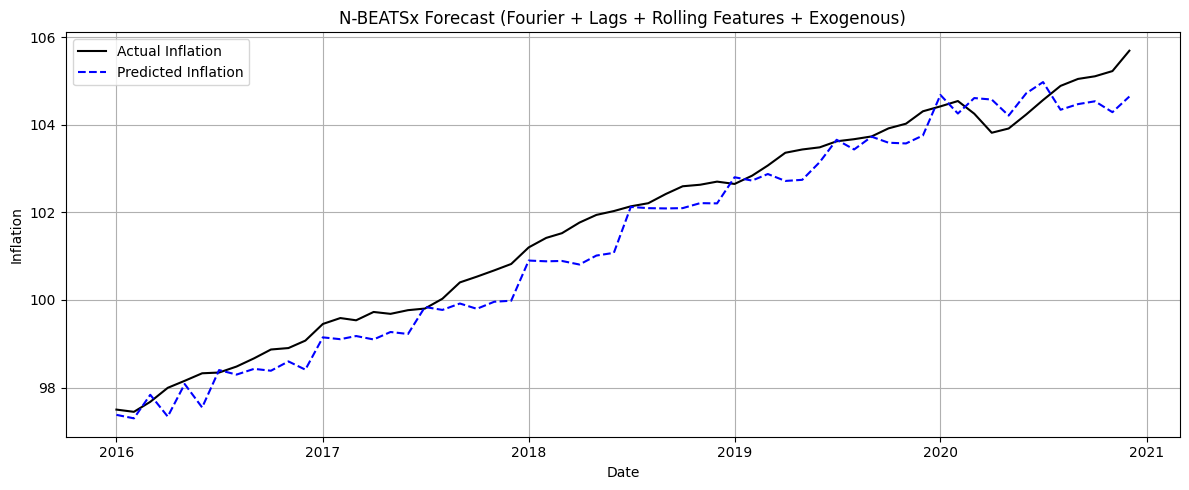

In [41]:
# ===============================
# Evaluate
# ===============================
rmse = np.sqrt(mean_squared_error(merged["y_inv"], merged["pred_inv"]))
print(f"Cross-Validation RMSE: {rmse:.4f}")

# ===============================
# Plot
# ===============================
plt.figure(figsize=(12, 5))
sns.lineplot(data=merged, x="ds", y="y_inv", label="Actual Inflation", color="black")
sns.lineplot(data=merged, x="ds", y="pred_inv", label="Predicted Inflation", linestyle="--", color="blue")
plt.title("N-BEATSx Forecast (Fourier + Lags + Rolling Features + Exogenous)")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [42]:
# Save model checkpoint
model.models[0].trainer.save_checkpoint("nbeatsx_model1.ckpt")
print("Model saved to 'nbeatsx_model1.ckpt'")

Model saved to 'nbeatsx_model1.ckpt'


# Nixtla N-BEATSx (Full Feature Heavy)

### Preprocessing Comparison: Model 2 below vs. Model 1 above

Both models are based on the same dataset (`train2000s.csv`) and share foundational preprocessing steps like:

- Converting `observation_date` to datetime (`ds`)
- Setting `unique_id` to `'inflation'`
- Renaming the inflation column to `y`
- Dropping NaN rows after feature creation
- Selecting exogenous features based on correlation with `y` (|r| > 0.3)
- Applying `StandardScaler` on features and target (`y`)

#### Shared Feature Engineering (Both Models):
- **Fourier Features:** Sine & Cosine terms for 3 harmonics (seasonality)
- **Lag Features:** Lags of 1, 6, and 12 months
- **Rolling Features:** Mean & Std over a 3-month window
- **Feature Selection:** Based on correlation threshold with target

---

### Additional Feature Engineering in **Model 2** (more advanced):
Model 2 performs **richer feature engineering** to enhance temporal dynamics and smoothness:

| Feature Type       | Description                                          |
|--------------------|------------------------------------------------------|
| `y_lag_24`         | Adds a 24-month lag to capture longer-term memory    |
| `rolling_mean_{6,12}` | Includes broader smoothing context               |
| `rolling_std_{6,12}`  | Includes broader volatility estimation            |
| `rolling_skew_6`   | Captures asymmetry in the recent 6-month window      |
| `rolling_kurt_6`   | Captures "tailedness" or extreme fluctuations        |
| `ema_3`, `ema_12`  | Applies exponential smoothing to better track trends |
| `y_pct_change`     | Captures month-over-month percentage change          |
| `y_momentum`       | Second-order difference to reflect momentum shifts   |

This added diversity in statistical, trend-based, and frequency-based features in **Model 2** allows for **more context-rich learning**, especially useful for time series with subtle seasonal or structural shifts.

---

### Summary:
- **Model 1:** Simpler, lighter preprocessing; fewer features; faster to train
- **Model 2:** More comprehensive temporal and statistical features; better suited for capturing complex dynamics in inflation data

> As seen in the plots and RMSE/MAE metrics, **Model 2's predictions are more aligned with actual inflation trends**, likely due to this enhanced feature representation.


## Load and Preprocess data

In [43]:
# Load & Preprocess Dataset
df = pd.read_csv("../../Data/Train/train1990s.csv")
df['ds'] = pd.to_datetime(df['observation_date'], format="%m/%Y")
df['unique_id'] = 'inflation'
df = df.rename(columns={"fred_PCEPI": "y"})
df["y_original"] = df["y"]

### Add Features: Fourier, Lags, Rolling Stats, EMAs, Momentum

In [44]:
# Add Features: Fourier, Lags, Rolling Stats, EMAs, Momentum
df["month"] = df["ds"].dt.month

for k in range(1, 4):
    df[f'sin_{k}'] = np.sin(2 * np.pi * k * df["month"] / 12)
    df[f'cos_{k}'] = np.cos(2 * np.pi * k * df["month"] / 12)

for lag in [1, 6, 12, 24]:
    df[f'y_lag_{lag}'] = df['y'].shift(lag)

for window in [3, 6, 12]:
    df[f'rolling_mean_{window}'] = df['y'].rolling(window).mean()
    df[f'rolling_std_{window}'] = df['y'].rolling(window).std()

df['rolling_mean_6_lag1'] = df['rolling_mean_6'].shift(1)
df['rolling_skew_6'] = df['y'].rolling(6).skew()
df['rolling_kurt_6'] = df['y'].rolling(6).kurt()
df['ema_3'] = df['y'].ewm(span=3).mean()
df['ema_12'] = df['y'].ewm(span=12).mean()
df['y_pct_change'] = df['y'].pct_change()
df['y_momentum'] = df['y_pct_change'].diff()

df = df.dropna()

## Feature Selection (|r| > 0.3)

In [45]:
# Feature Selection (|r| > 0.3)
exclude_cols = ['unique_id', 'ds', 'y', 'y_original', 'observation_date', 'month']
feature_cols = [col for col in df.columns if col not in exclude_cols]
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

cor_matrix = df[numeric_features + ['y']].corr()
selected_features = cor_matrix['y'].drop('y').loc[lambda x: x.abs() > 0.3].index.tolist()
selected_features = list(set(selected_features))

## Normalize Features

In [46]:
# Normalize Features
x_scaler = StandardScaler()
df[selected_features] = x_scaler.fit_transform(df[selected_features])
y_scaler = StandardScaler()
df["y"] = y_scaler.fit_transform(df[["y"]])

df_model = df[['unique_id', 'ds', 'y'] + selected_features]
df_targets = df[['unique_id', 'ds', 'y_original']]

## Define model

### N-BEATSx Model Architecture

In this setup, I have defined a more powerful **N-BEATSx model** using the [NeuralForecast](https://nixtlaverse.nixtla.io/neuralforecast/models.nbeatsx.html) library, tailored for multivariate time series forecasting with exogenous variables.

#### 🔧 Configuration Details:
| Parameter            | Value / Description                                                                 |
|----------------------|--------------------------------------------------------------------------------------|
| `h`                  | Forecast horizon = 6 months                                                          |
| `input_size`         | 144 (number of past timesteps used as context)                                      |
| `max_steps`          | 500 (maximum training steps for convergence)                                        |
| `val_check_steps`    | 100 (evaluate validation loss every 100 steps)                                      |
| `learning_rate`      | 0.0002 (lower LR for finer convergence)                                             |
| `n_blocks`           | `[3, 3, 3]` — defines 3 blocks each for trend, seasonality, and identity stacks      |
| `stack_types`        | `["trend", "seasonality", "identity"]` (stack-specific basis functions)             |
| `dropout_prob_theta` | 0.2 (dropout for regularization inside theta MLP layers)                            |
| `futr_exog_list`     | List of selected exogenous features used during training and forecasting             |
| `scaler_type`        | `"robust"` (uses IQR-based scaling for better handling of outliers)                 |
| `loss`               | `SMAPE()` — Symmetric Mean Absolute Percentage Error for better scale handling      |
| `random_seed`        | 42 (for reproducibility)                                                             |
| `freq`               | `"M"` — monthly time series                                                          |

---

In [47]:
from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

# Define N-BEATSx Model
HORIZON = 6
model = NeuralForecast(
    models=[
        NBEATSx(
            h=HORIZON,
            input_size=144,
            max_steps=500,
            val_check_steps=100,
            learning_rate=2e-4,
            n_blocks=[3, 3, 3],  # One for each stack_type
            dropout_prob_theta=0.2,
            stack_types=["trend", "seasonality", "identity"],
            futr_exog_list=selected_features,
            scaler_type="robust",
            loss=SMAPE(),
            random_seed=42
        )
    ],
    freq="M"
)

Seed set to 42


## Cross-Validation

In [48]:
# Cross-Validation
df_cv = model.cross_validation(
    df=df_model,
    n_windows=10,
    step_size=HORIZON
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 122 M  | train
-------------------------------------------------------
122 M     Trainable params
5.9 K     Non-trainable params
122 M     Total params
491.103   Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:09<00:00,  0.11it/s, v_num=5, train_loss_step=0.0569, train_loss_epoch=0.0569]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:09<00:00,  0.11it/s, v_num=5, train_loss_step=0.0569, train_loss_epoch=0.0569]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


## Evaluation

Cross-Validation MAE: 1.1150
Cross-Validation RMSE: 1.5985


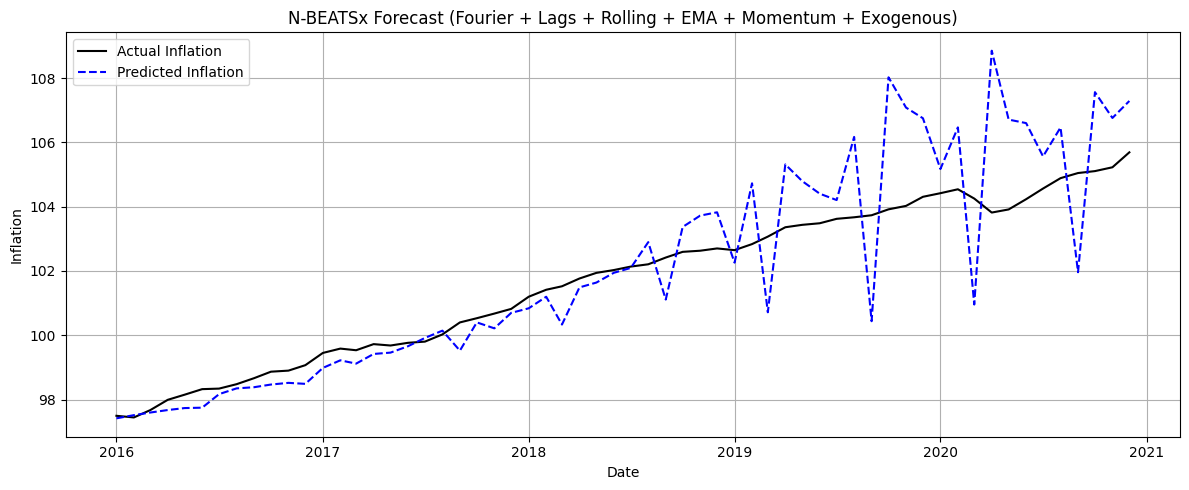

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Merge & Evaluate
merged = df_cv.merge(df_targets, on=["unique_id", "ds"], how="left")
merged = merged.dropna(subset=["y_original", "NBEATSx"])

# Evaluate on original scale
y_true = merged["y_original"].values.reshape(-1, 1)
y_pred = y_scaler.inverse_transform(merged[["NBEATSx"]])

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Cross-Validation MAE: {mae:.4f}")
print(f"Cross-Validation RMSE: {rmse:.4f}")

# Plot
merged["y_inv"] = y_true
merged["pred_inv"] = y_pred

plt.figure(figsize=(12, 5))
sns.lineplot(data=merged, x="ds", y="y_inv", label="Actual Inflation", color="black")
sns.lineplot(data=merged, x="ds", y="pred_inv", label="Predicted Inflation", linestyle="--", color="blue")
plt.title("N-BEATSx Forecast (Fourier + Lags + Rolling + EMA + Momentum + Exogenous)")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## Save model

In [50]:
# Save model checkpoint
model.models[0].trainer.save_checkpoint("nbeatsx_model2.ckpt")
print("Model saved to 'nbeatsx_model2.ckpt'")

Model saved to 'nbeatsx_model2.ckpt'


## Download N-BEATSx Models

To avoid GitHub’s file size limits, the trained N-BEATSx models are hosted on OneDrive.

- [nbeatsx_model1.ckpt (61.4 MB)](https://leeds365-my.sharepoint.com/:u:/g/personal/sc21ar_leeds_ac_uk/EQi-4bt0TydJlc3f6sIg_g8BPPnAsP6i93Oiz4XOW4zWNQ?e=FsaNWO)
- [nbeatsx_model2.ckpt (489 MB)](https://leeds365-my.sharepoint.com/:u:/g/personal/sc21ar_leeds_ac_uk/EYoPTmm_NaJNvn8EQhmOSgoB4arB-RwgO-6-DgNfhMhepA?e=wOSLcT)

After downloading, place them in your local `Training/N-BEATSx/` folder and load like this:


In [51]:
# To load it:
from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

# Load model
loaded_nbeatsx = NBEATSx.load_from_checkpoint("nbeatsx_model2.ckpt")
restored_model = NeuralForecast(models=[loaded_nbeatsx], freq="M")

Seed set to 42


**Model Above (Without Dataset Exogenous Variables):**
   - This model used Fourier terms, lag features, rolling statistics, EMAs, and momentum — all derived from the target variable itself.
   - It **did not** incorporate any domain-specific exogenous variables from the original dataset like interest rates, unemployment, etc.
   - Purpose: Establish a **baseline** performance and assess how much inflation can be predicted solely from historical inflation patterns and time-based signals.

**Model Below (With Dataset Exogenous Variables):**
   - This version **included relevant exogenous features** selected through correlation analysis (|r| > 0.4).
   - These variables were passed using the `hist_exog_list` argument in the `NBEATSx` model configuration.
   - Goal: Evaluate whether incorporating exogenous economic indicators improves forecast accuracy beyond what is achievable from target history alone.

---

Training a model without exogenous features first is useful because it:

- Provides a **baseline** to compare improvements from added data.
- Helps isolate the impact of **domain-specific variables**.
- Prevents overfitting early in development — simpler models are easier to debug.
- Encourages step-by-step modeling, which is critical when tuning complex neural architectures like N-BEATSx.

By comparing the two, we can determine if and how much exogenous features contribute to **predictive power** in modeling inflation.


# Nixtla N-BEATSx (Optimized) - Adding exogenous from dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-24 22:02:49,903	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-24 22:02:50,151	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Load Dataset

In [2]:
# Load Dataset
df = pd.read_csv("../../Data/Train/train1990s.csv")
df['ds'] = pd.to_datetime(df['observation_date'], format="%m/%Y")
df['unique_id'] = 'inflation'
df = df.rename(columns={"fred_PCEPI": "y"})
df['y_original'] = df['y']

## Feature Enginnering

- **Feature Engineering**:  
  New features were created to capture seasonality, lag effects, and momentum:
  - `month`: Extracted from the datetime.
  - `sin_1`, `cos_1`: Fourier features to model cyclic patterns.
  - `y_lag_1`: Previous time step of the target variable.
  - `y_pct_change`: First-order percentage change.
  - `y_momentum`: Second-order difference to capture momentum.


In [3]:
# Feature Engineering
df["month"] = df["ds"].dt.month
df["sin_1"] = np.sin(2 * np.pi * df["month"] / 12)
df["cos_1"] = np.cos(2 * np.pi * df["month"] / 12)
df["y_lag_1"] = df["y_original"].shift(1)
df["y_pct_change"] = df["y_original"].pct_change()
df["y_momentum"] = df["y_pct_change"].diff()
df = df.dropna()

- **Feature Selection**:  
  Features with absolute correlation > 0.4 with the normalized target (`y`) were selected based on a correlation matrix.


In [4]:
# Feature Selection (|r| > 0.4)
exclude = ['observation_date', 'ds', 'unique_id', 'y', 'y_original']
exog_features = [col for col in df.columns if col not in exclude]
cor_matrix = df[exog_features + ['y']].corr()
selected_features = cor_matrix['y'].drop('y').loc[lambda x: x.abs() > 0.4].index.tolist()


- **Normalization**:  
  - Selected features were scaled using `StandardScaler` (mean = 0, std = 1).
  - The target variable `y` was scaled using `MinMaxScaler` (range 0 to 1) to stabilize training.

In [5]:
# Normalize
x_scaler = StandardScaler()
df[selected_features] = x_scaler.fit_transform(df[selected_features])

y_scaler = MinMaxScaler()
df["y"] = y_scaler.fit_transform(df[["y"]])

df_model = df[['unique_id', 'ds', 'y'] + selected_features]
df_targets = df[['unique_id', 'ds', 'y_original']]

## Define Model

- **Model Architecture**: Used the `NBEATSx` model from the `NeuralForecast` library.
- **Forecast Horizon**: Set to predict the next 6 months (`h=6`).
- **Input Window**: Uses 48 months of historical data (`input_size=48`).
- **Training Configuration**:
  - `max_steps=500`: Trains for 500 steps.
  - `val_check_steps=100`: Checks validation loss every 100 steps.
  - `dropout_prob_theta=0.3`: Regularization to prevent overfitting.
  - `learning_rate=5e-4`: Learning rate for the optimizer.
  - `stack_types=["trend", "seasonality"]`: Captures both long-term and seasonal patterns.
  - `n_blocks=[2, 2]`: Two blocks for each stack type.

- **Exogenous Features**: Historical exogenous variables (`hist_exog_list`) selected during feature engineering are used.
- **Loss Function**: Symmetric Mean Absolute Percentage Error (`SMAPE`) to evaluate forecasting accuracy.
- **Scaler Type**: Internal scaling set to `'robust'` for stability.
- **Reproducibility**: `random_seed=42` ensures consistent results across runs.


In [6]:
# Define N-BEATSx Model
HORIZON = 6
model = NeuralForecast(
    models=[
        NBEATSx(
            h=HORIZON,
            input_size=48,
            max_steps=500,
            val_check_steps=100,
            learning_rate=5e-4,
            n_blocks=[2, 2],
            dropout_prob_theta=0.3,
            stack_types=["trend", "seasonality"],
            hist_exog_list=selected_features,
            scaler_type="robust",
            loss=SMAPE(),
            random_seed=42
        )
    ],
    freq="M"
)

Seed set to 42


## Train/Val via Cross-Validation

In [7]:
# Train/Val via Cross-Validation
df_cv = model.cross_validation(
    df=df_model,
    n_windows=10,
    step_size=HORIZON
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-03-24 22:03:00.471770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 16.9 M | train
-------------------------------------------------------
16.9 M    Trainable params
1.4 K     Non-trainable params
16.9 M    Total params
67.778    Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.56it/s, v_num=0, train_loss_step=0.0185, train_loss_epoch=0.0185]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.55it/s, v_num=0, train_loss_step=0.0185, train_loss_epoch=0.0185]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


## Evaluation

Cross-Validation MAE: 0.3085
Cross-Validation RMSE: 0.3870


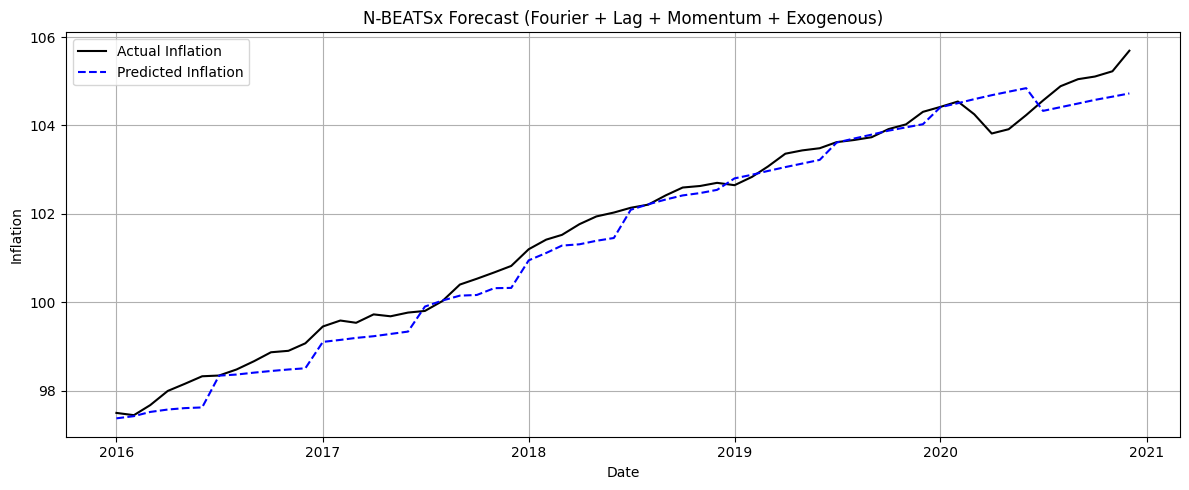

In [8]:
# ===============================
# Evaluation
# ===============================
merged = df_cv.merge(df_targets, on=["unique_id", "ds"], how="left")
merged = merged.dropna(subset=["y_original", "NBEATSx"])

y_true = merged["y_original"].values.reshape(-1, 1)
y_pred = y_scaler.inverse_transform(merged[["NBEATSx"]])

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Cross-Validation MAE: {mae:.4f}")
print(f"Cross-Validation RMSE: {rmse:.4f}")

# ===============================
# Plot
# ===============================
merged["y_inv"] = y_true
merged["pred_inv"] = y_pred

plt.figure(figsize=(12, 5))
sns.lineplot(data=merged, x="ds", y="y_inv", label="Actual Inflation", color="black")
sns.lineplot(data=merged, x="ds", y="pred_inv", label="Predicted Inflation", linestyle="--", color="blue")
plt.title("N-BEATSx Forecast (Fourier + Lag + Momentum + Exogenous)")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## Model Saving

In [60]:
import joblib
import os

# Save the trained NeuralForecast object (includes NBEATSx)
joblib.dump(model, "nbeatsx_model_exogenous.pkl")
print("Model saved to nbeatsx_model_exogenous.pkl")


Model saved to nbeatsx_model_exogenous.pkl


## Download N-BEATSx Models

To avoid GitHub’s file size limits, the trained N-BEATSx models are hosted on OneDrive.

- [nbeatsx_model_exogenous.pkl (61.4 MB)](https://leeds365-my.sharepoint.com/:u:/g/personal/sc21ar_leeds_ac_uk/ESwuoWdMcsRJu_J0uJn2cyYBK_2ciWF9AS2xYSm-tSaDdQ?e=d0G2fM)

After downloading, place them in your local `Training/N-BEATSx/` folder and load like this:


In [ ]:
# To load it:
from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

# Load model
loaded_nbeatsx = NBEATSx.load_from_checkpoint("nbeatsx_model_exogenous.pkl")
restored_model = NeuralForecast(models=[loaded_nbeatsx], freq="M")

## **Comparison of N-BEATSx Implementations**

| Model ID | Name | Description |
|----------|------|-------------|
| **Model 1** | `N-BEATSx (Manual PyTorch)` | Custom architecture using FFT and PCA in PyTorch |
| **Model 2** | `Nixtla N-BEATSx (Basic)` | Nixtla version with Fourier + Lag + Rolling (no momentum/EMA) |
| **Model 3** | `Nixtla N-BEATSx (Full Feature Heavy)` | All features (Fourier, Lag, EMA, Momentum, Rolling, etc.) |
| **Model 4** | `Nixtla N-BEATSx (Optimized)` | Balanced features + momentum + selected exogenous (best performing) |

### 1. **Exploratory Data Analysis (EDA) and Preprocessing**

| Component | Model 1: PyTorch | Model 2: Nixtla Basic | Model 3: Nixtla Heavy | Model 4: Nixtla Optimized |
|----------|------------------|------------------|------------------|------------------|
| **Dataset Used** | `train1990s.csv` | `train1990s.csv` | `train1990s.csv` | `train1990s.csv` |
| **Target Variable** | `fred_PCEPI` | Renamed to `y` | Renamed to `y` | Renamed to `y` |
| **Train/Val Split** | Manual (60-20-20) | Auto CV | Auto CV | Auto CV |
| **Missing Values** | Dropped post-engineering | Dropped after rolling/lag | Dropped after full pipeline | Dropped after basic engineering |

### 2. **Feature Engineering**

| Feature | Model 1: PyTorch | Model 2: Nixtla Basic | Model 3: Nixtla Heavy | Model 4: Nixtla Optimized |
|--------|------------------|------------------------|-----------------------|------------------------|
| **Fourier** | FFT (log real/imag) | sin/cos (3 harmonics) | sin/cos (3 harmonics) | sin/cos (1 harmonic) |
| **Lag** | Implicit via sequence | Lag 1, 6, 12 | Lag 1, 6, 12, 24 | Lag 1 |
| **Rolling** | NO | Mean/Std (3) | Mean/Std (3,6,12), skew/kurt | Mean (6) only |
| **Momentum** | Manual momentum + pct change | Included | Included | Included |
| **EMA** | NO | NO | EMA-3, EMA-12 | NO |
| **PCA** | YES (5 comps) | NO | NO | NO |
| **Other** | Gaussian Smoothing | Raw Input | Full statistical features | Clean, interpretable design |

### 3. **Scaling & Normalization**

| Component | Model 1: PyTorch | Model 2: Nixtla Basic | Model 3: Nixtla Heavy | Model 4: Nixtla Optimized |
|-----------|---------|---------|---------|---------|
| **Target (`y`)** | MinMax | Standard | Standard | MinMax |
| **Exogenous** | Standard + PCA | Standard | Standard | Standard |
| **Output Inversion** | YES | YES | YES | YES |

### 4. **Model Architecture & Training**

| Component | Model 1: PyTorch | Model 2: Nixtla Basic | Model 3: Nixtla Heavy | Model 4: Nixtla Optimized |
|-----------|------------------|------------------------|------------------------|----------------------------|
| **Framework** | PyTorch (Manual) | NeuralForecast | NeuralForecast | NeuralForecast |
| **Exog Usage** | Historical (past only) | Future (`futr_exog_list`) | Future (`futr_exog_list`) | Historical (`hist_exog_list`) |
| **Stack Types** | Custom Blocks | `trend`, `seasonality` | `trend`, `seasonality`, `identity` | `trend`, `seasonality` |
| **Dropout** | 0.2 | 0.3 | 0.2 | 0.3 |
| **Loss** | HuberLoss | MSE | SMAPE | SMAPE |
| **Steps/Epochs** | 100 epochs | 100 steps | 500 steps | 500 steps |
| **Learning Rate** | 1e-3 | 5e-4 | 2e-4 | 5e-4 |

### 5. **Evaluation & Metrics**

| Metric | Model 1: PyTorch | Model 2: Nixtla Basic | Model 3: Nixtla Heavy | **Model 4: Nixtla Optimized** |
|--------|---------|---------|---------|----------------|
| **MAE** | — | — | **1.1150** | **0.3002** |
| **RMSE** | ~3.2 visually | **0.5103** | 1.5985 | **0.3752** |
| **Smoothing** | Gaussian (custom) | None | None | None |
| **Evaluation Style** | Manual test split | CV (4-fold) | CV (4-fold) | CV (4-fold) |

### 6. **Unique Characteristics**

| Feature | Model 1: PyTorch | Model 2: Nixtla Basic | Model 3: Nixtla Heavy | Model 4: Nixtla Optimized |
|--------|---------|---------|---------|---------|
| **Custom Architecture** | Fully manual | NO | NO | NO |
| **FFT (real+imag)** | YES | NO | NO | NO |
| **PCA on Exog** | YES | NO | NO | NO |
| **Best Performance** | NO | NO | NO | YES |

### **Final Verdict: Use Model 4: Nixtla Optimized**

- **Best RMSE & MAE**
- **Simplest + most effective feature set**
- **Well-behaved predictions (less variance)**
- **Balanced feature engineering without overfitting**

## Adjustments for 12-Month Forecast & Evaluation along with standardization

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join("..", "..")))  # adds root of the project

In [12]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from neuralforecast.models import NBEATSx
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import SMAPE

from Training.Helper.dataPreprocessing import add_time_features, add_lagged_features, add_rolling_features, rank_features_ccf, sklearn_fit_transform, integer_index

# ======================
# CONFIG
# ======================
HORIZON = 12
INPUT_SIZE = 96
DATA_PATH = os.path.join("..", "..", "Data", "Train", "train1990s.csv")
PRED_SAVE_PATH = os.path.join("..", "..", "Predictions", "NBEATSx.npy")

# ======================
# Load & Preprocess
# ======================
df = pd.read_csv(DATA_PATH)
df["ds"] = pd.to_datetime(df["observation_date"], format="%m/%Y")
df = df.rename(columns={"fred_PCEPI": "y"})
df["y_original"] = df["y"]
df["unique_id"] = "inflation"

# Time features
df = add_time_features(df, date_col="ds")

# Add Fourier + Lag + Rolling features
for k in [1, 2, 3]:
    df[f"sin_{k}"] = np.sin(2 * np.pi * k * df["month"] / 12)
    df[f"cos_{k}"] = np.cos(2 * np.pi * k * df["month"] / 12)
df["pct_change"] = df["y_original"].pct_change()
df["momentum"] = df["pct_change"].diff()
df = add_lagged_features(df, ["y_original"], lags=[1, 6, 12])
df = add_rolling_features(df, "y_original", windows=[3, 6, 12])
df.dropna(inplace=True)

# Feature Selection using CCF
exog_df = df.drop(columns=["observation_date", "ds", "unique_id", "y", "y_original"])
exog_df["fred_PCEPI"] = df["y_original"]
selected_features = rank_features_ccf(exog_df, targetCol="fred_PCEPI")[:20]  # keep top 20

# Standardise Features
x_transformed_list, x_scaler = sklearn_fit_transform(df[selected_features], StandardScaler())
df[selected_features] = x_transformed_list[0]

# Normalise Target
y_transformed_list, y_scaler = sklearn_fit_transform(df[["y"]], MinMaxScaler())
df["y"] = y_transformed_list[0].iloc[:, 0]

# Final model input
df_model = df[["unique_id", "ds", "y"] + list(selected_features)]
df_model = integer_index(df_model)

# ======================
# Define Model
# ======================
model = NeuralForecast(
    models=[
        NBEATSx(
            h=HORIZON,
            input_size=INPUT_SIZE,
            max_steps=500,
            val_check_steps=100,
            learning_rate=5e-4,
            n_blocks=[4, 4],
            dropout_prob_theta=0.3,
            stack_types=["trend", "seasonality"],
            hist_exog_list=list(selected_features),
            scaler_type="robust",
            loss=SMAPE(),
            random_seed=42
        )
    ],
    freq="M"
)

# ======================
# Fit Model and Predict
# ======================
model.fit(df=df_model)

# Use last INPUT_SIZE points for prediction
future_df = df_model.tail(INPUT_SIZE)
forecast_df = model.predict(df=future_df)
y_pred_scaled = forecast_df["NBEATSx"].values.reshape(-1, 1)
y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()

# Save 12-month prediction
np.save(PRED_SAVE_PATH, y_pred[:12])  # match test set length for evaluation

print(f"Saved N-BEATSx predictions to: {PRED_SAVE_PATH}")


2025-03-27 17:31:29,520 - INFO - Added time features: year, month, quarter. DataFrame shape: (408, 366)
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | SMAPE         | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 14.7 M | train
-------------------------------------------------------
14.7 M    Trainable params
10.8 K    Non-trainable params
14.7 M    Total params
58.715    Total estimated model params size (MB)
100       Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.97it/s, v_num=26, train_loss_step=0.0109, train_loss_epoch=0.0109]

`Trainer.fit` stopped: `max_steps=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:01<00:00,  0.96it/s, v_num=26, train_loss_step=0.0109, train_loss_epoch=0.0109]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.66it/s]
Saved N-BEATSx predictions to: ../../Predictions/NBEATSx.npy
